# 1. Defining the problem

1. Predict if a passenger survived the sinking of the Titanic or no

Sub tasks:

1. Analise by using Decision Tree who had higher survival chances. 
2. Provide recomendations for key changes, which might help to save more lives in the future.

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# 2. Collecting the data

Loading training and test datasets using Pandas


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
sns.set()
from yellowbrick.classifier import ConfusionMatrix

#Loading data
titanic_train = pd.read_csv('train.csv')
#titanic_test = pd.read_csv('../input/titanic/test.csv')
titanic_test = pd.read_csv('test.csv')

# 3. Exploring the data

In [17]:
#preview data
titanic_train.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [18]:
titanic_train.groupby(['Pclass','Sex'])['Survived'].sum() # grouping data

Pclass  Sex   
1       female    91
        male      45
2       female    70
        male      17
3       female    72
        male      47
Name: Survived, dtype: int64

# Missing values

In [19]:
titanic_train.isnull().sum() # Check with alues are empty

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

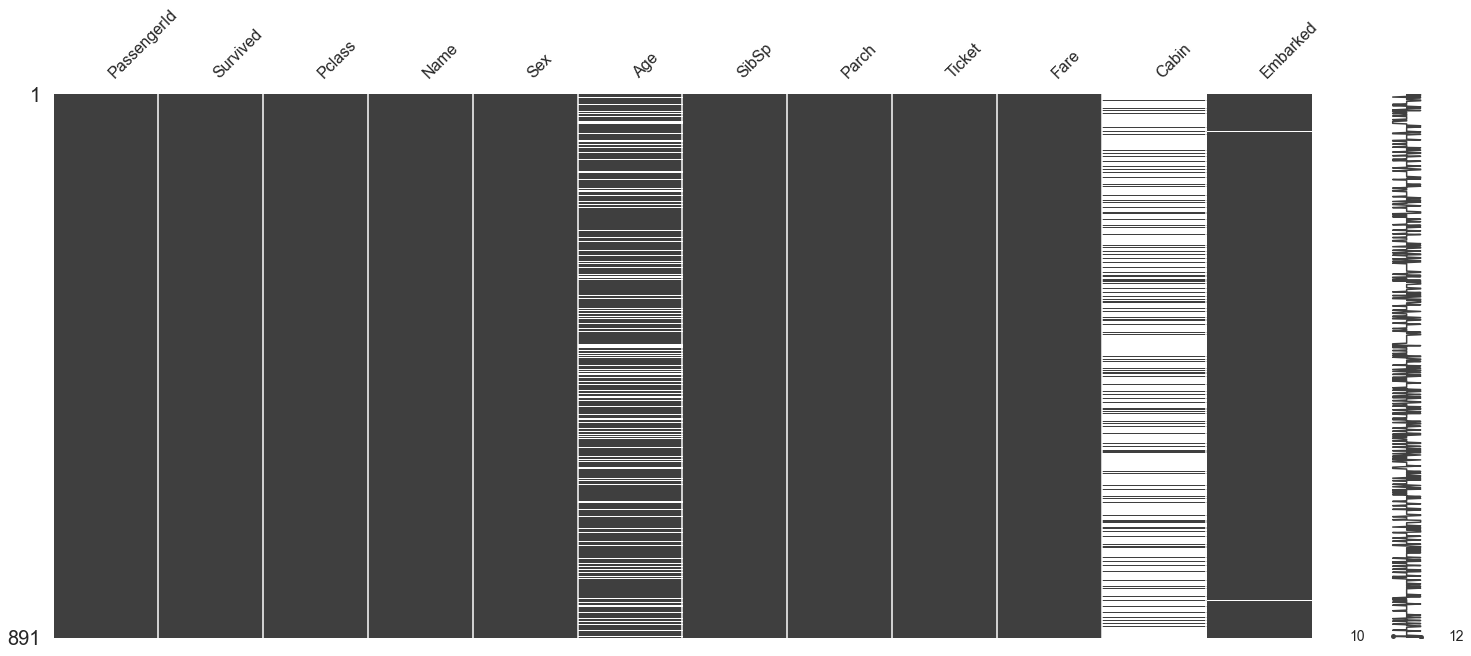

In [20]:
#Missing values in the plot
import missingno as msno
msno.matrix(titanic_train)

In [21]:
titanic_train['_Sex'] = pd.Categorical(titanic_train.Sex).codes #male=1, female =0
titanic_train['_Embarked'] = pd.Categorical(titanic_train.Embarked).codes #S=2, C=0,Q=1 
titanic_train['_CabinType'] = pd.Categorical(titanic_train['Cabin'].astype(str).str[0]).codes


In [22]:
#completing missing data

#pulling out the titles
pat = r",\s([^ .]+)\.?\s+"
titanic_train['Title'] =  titanic_train['Name'].str.extract(pat,expand=True)[0]
titanic_train.loc[titanic_train['Title'].isin(['Mlle','Ms','Lady']),'Title'] = 'Miss'
titanic_train.loc[titanic_train['Title'].isin(['Mme']),'Title'] = 'Mrs'
titanic_train.loc[titanic_train['Title'].isin(['Sir']),'Title'] = 'Mr'
titanic_train.loc[~titanic_train['Title'].isin(['Miss','Master','Mr','Mrs']),'Title'] = 'Other' # NOT IN
titanic_train['_Title'] = pd.Categorical(titanic_train.Title).codes
titanic_train.groupby('Title')['Title'].count()

Title
Master     40
Miss      186
Mr        518
Mrs       126
Other      21
Name: Title, dtype: int64

In [23]:
#new value - Family Size and TravelAlone
#for train
titanic_train['_FamilySize'] = titanic_train['SibSp'] + titanic_train['Parch'] + 1
titanic_train['_IsAlone'] = 0
titanic_train.loc[titanic_train['_FamilySize'] == 1, '_IsAlone'] = 1


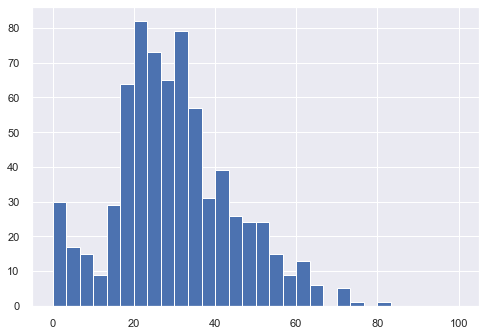

In [24]:
plt_all = plt.hist(titanic_train['Age'],bins = 30,  range = [0,100],label='all')

In [25]:
titanic_train[['Age','_Embarked','Fare','Parch','Pclass','_Sex','SibSp','Survived','_CabinType','_Title']].corr()['Age'].abs().sort_values(ascending=False)

Age           1.000000
_Title        0.502058
Pclass        0.369226
SibSp         0.308247
_CabinType    0.267270
Parch         0.189119
Fare          0.096067
_Sex          0.093254
Survived      0.077221
_Embarked     0.044830
Name: Age, dtype: float64

In [26]:
#Add Age using linear regression model
cols = ['Pclass','_CabinType','SibSp','Fare','Parch']

ageData = titanic_train[titanic_train['Age'].notnull()]
emptyData = titanic_train[titanic_train['Age'].isnull()]
Y = ageData['Age'] 
X = ageData[cols] # ,'Parch','Embarked']]

# Create linear regression object
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X,Y)

X = emptyData[cols]
Y = regr.predict(X)
# First we need to set index before 

pred =  pd.concat([pd.Series(Y,emptyData.index),ageData['Age']]).sort_index()
titanic_train['_Age'] = pred

# Calculate AgeCategory
titanic_train['AgeCategory'] = pd.cut(titanic_train['_Age'],[0,9,18,30,40,50,100], labels=[9,18,30,40,50,100]) # Add column with range of Age
titanic_train['_AgeCategory'] = titanic_train['AgeCategory'].cat.codes # Add column with range of Age

In [27]:
titanic_train.drop(['PassengerId','Name','Sex','Ticket','Cabin','Title','Embarked','Age','AgeCategory'], axis=1, inplace=True)


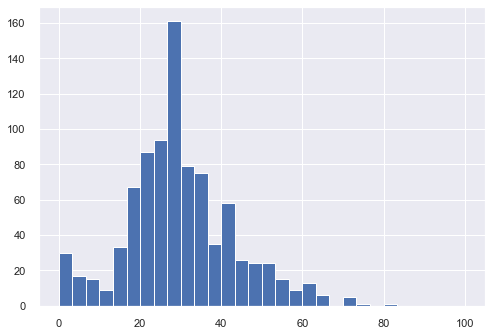

In [28]:
plt_all = plt.hist(titanic_train['_Age'],bins = 30,  range = [0,100],label='all')

<AxesSubplot:>

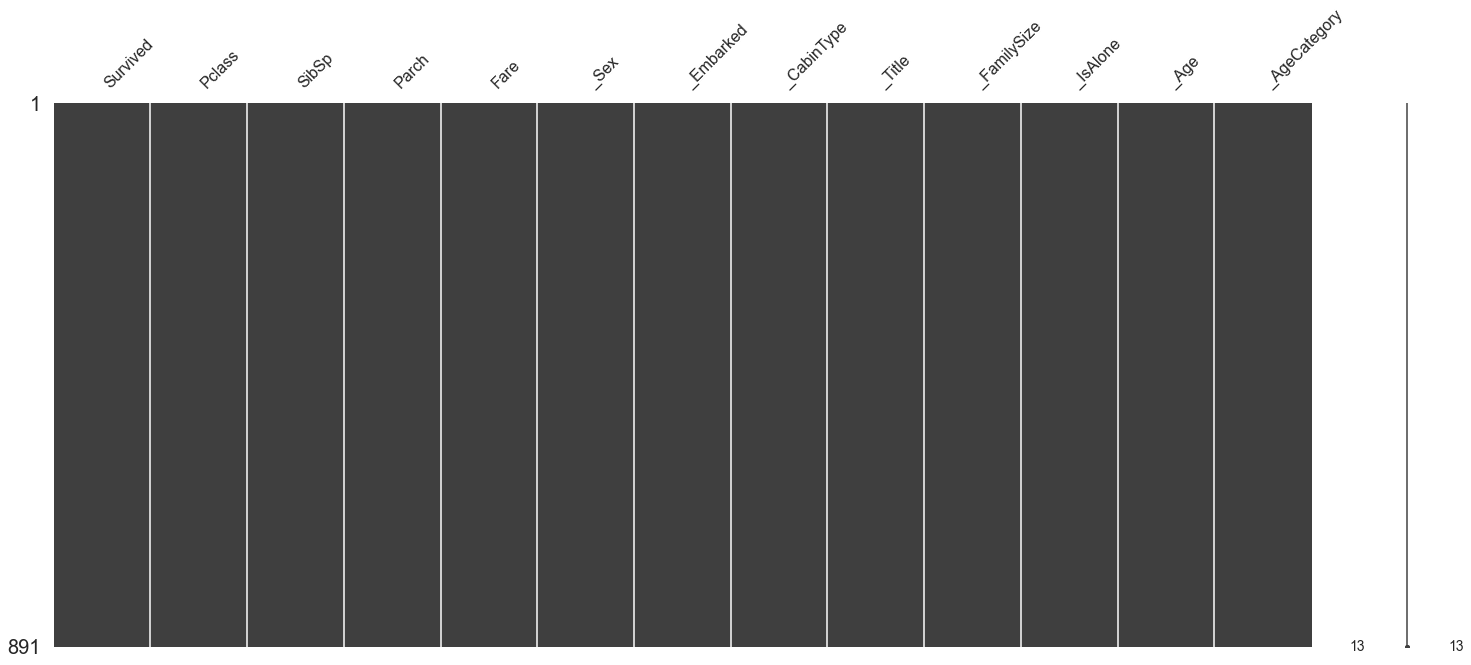

In [29]:
#Missing values in the plot
import missingno as msno
msno.matrix(titanic_train)

# 4. Preparing the model

In [30]:
X = titanic_train.iloc[:,2:]

y = titanic_train.iloc[:,1]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [32]:
#Decision Tree
tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=40)
tree.fit(X_train, y_train)

print('Dokładność testu: ', tree.score(X_test, y_test))

Dokładność testu:  0.8994413407821229


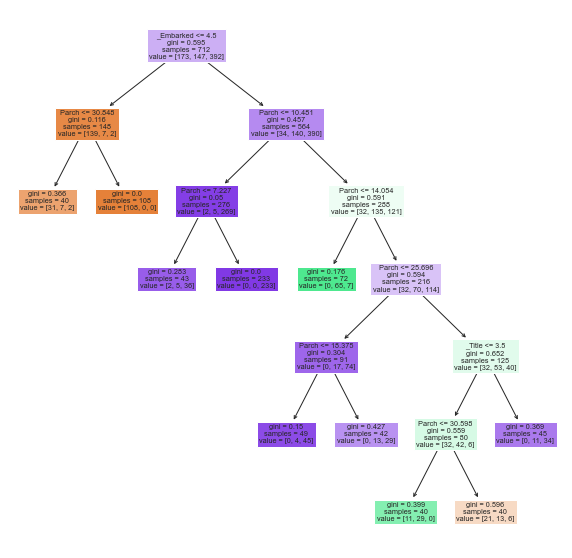

In [33]:
plt.subplots(figsize=(10,10))
plot_tree(tree, filled=True, feature_names=titanic_train.columns[1:])
plt.show()

In [34]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=10)
clf.fit(X, y)

print('Dokładność modelu: ' + str(round(clf.score(X, y), 4) * 100) + '%')

scores = cross_val_score(clf, X, y, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Dokładność modelu: 99.66000000000001%
Scores: [0.9        0.94382022 0.94382022 0.95505618 0.91011236 0.95505618
 0.8988764  0.98876404 0.8988764  0.92134831]
Mean: 0.9315730337078652
Standard Deviation: 0.02893754729986375


In [35]:
def bar_chart(feature, stack):
    survived = titanic_train[titanic_train['Survived']==1][feature].value_counts()
    dead = titanic_train[titanic_train['Survived']==0][feature].value_counts()
    my_colors = 'rbkgymc' 
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',color = my_colors, stacked=stack, figsize=(10,5))

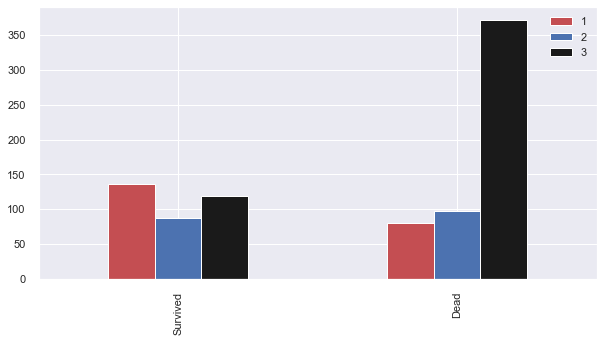

In [36]:
bar_chart('Pclass',False) 

1st class has the highest chance to survive. 3rd class has the lowest chance to survive.

The Chart confirms a person aboarded with more than 2 parents or children more likely survived
The Chart confirms a person aboarded alone more likely dead

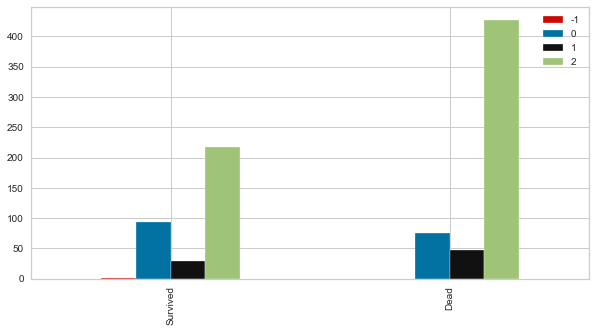

In [28]:
bar_chart('_Embarked', False)

The Chart confirms a person aboarded from C slightly more likely survived \
The Chart confirms a person aboarded from Q more likely dead \
The Chart confirms a person aboarded from S more likely dead 

# 5. Features Engineering

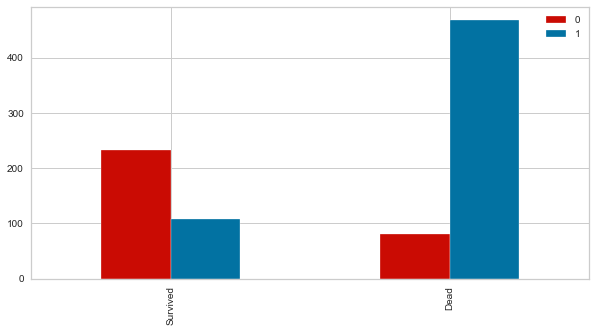

In [24]:
bar_chart('_Sex', False)  #Charts shows that woman has higher chance to survive.

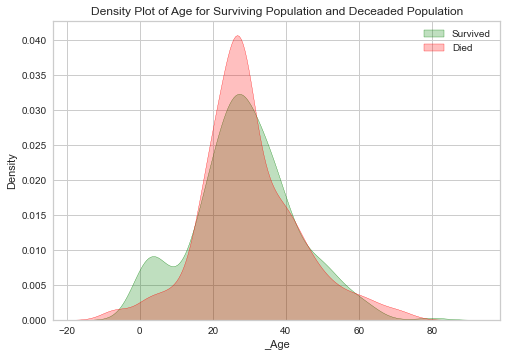

In [29]:
#Measuring the role of Age in survival chances
plt.figure()
sns.kdeplot(titanic_train['_Age'][titanic_train['Survived'] == 1], color='Green', shade=True)
sns.kdeplot(titanic_train['_Age'][titanic_train['Survived'] == 0], color='Red', shade=True)
plt.legend(['Survived','Died'])
plt.title('Density Plot of Age for Surviving Population and Deceaded Population')
plt.show()

/Users/karolszymczyk/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


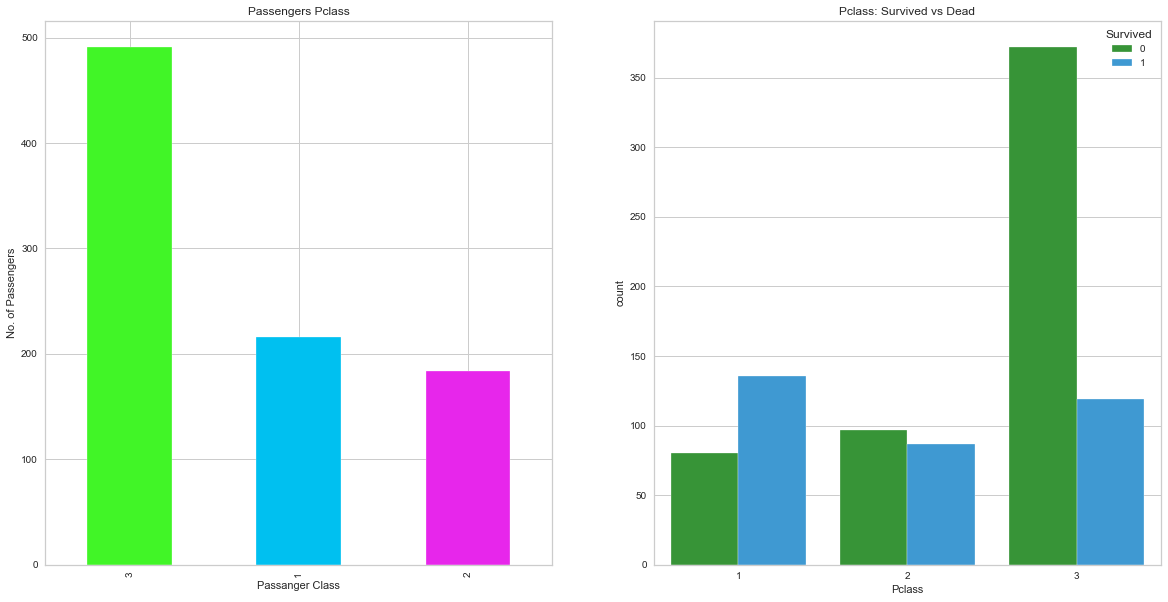

In [30]:
#Measuring the role of Ticket Class in survival chances
fig, a = plt.subplots(1,2,figsize=(20,10))
titanic_train['Pclass'].value_counts().plot.bar(color=['#41F527','#00C0F0','#E726EB'], ax=a[0])
a[0].set_title('Passengers Pclass')
a[0].set_xlabel('Passanger Class')
a[0].set_ylabel('No. of Passengers')
sns.countplot('Pclass', hue='Survived', data=titanic_train, palette=['#28A427','#269EEB'], ax=a[1])
a[1].set_title('Pclass: Survived vs Dead')
plt.show()

[Text(0, 0, 'Alone'), Text(1, 0, 'With Family')]

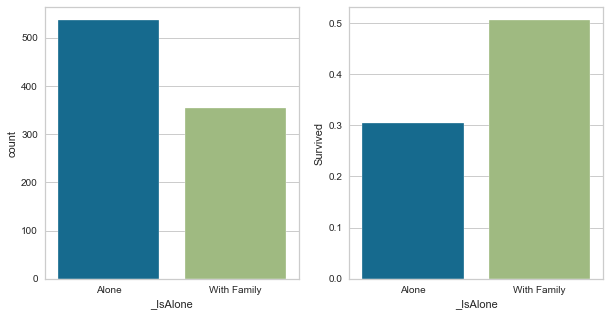

In [34]:
#Measuring the role of having family in survival chances
fig, (axis1,axis2) = plt.subplots(1,2, sharex=True, figsize=(10,5))

sns.countplot(x='_IsAlone', data=titanic_train, order=[1,0], ax=axis1)

family_grouped = titanic_train[['_IsAlone','Survived']].groupby(['_IsAlone'], as_index=False).mean()
sns.barplot(x='_IsAlone', y='Survived', data=family_grouped, order=[1,0], ax=axis2)

axis1.set_xticklabels(['Alone','With Family'], rotation=0)

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

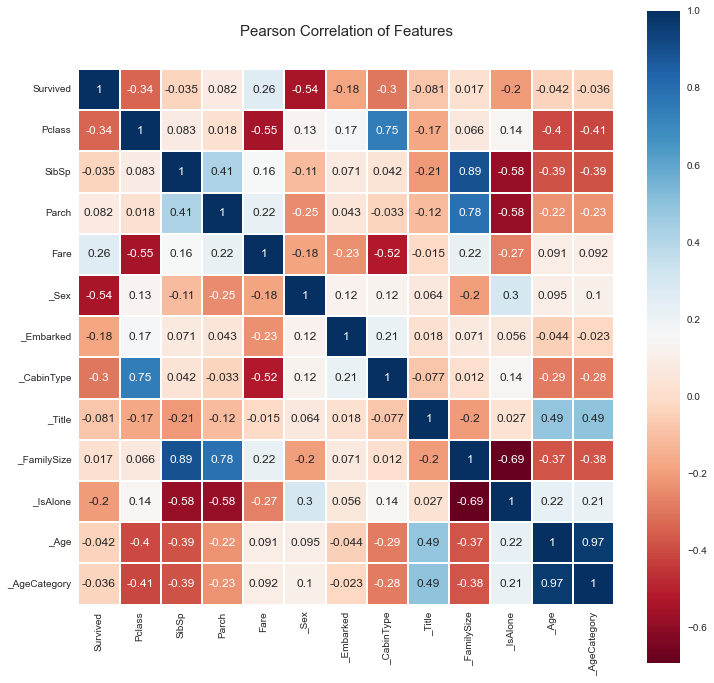

In [36]:
colormap = plt.cm.RdBu
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(titanic_train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)